Adapted in notebook GP_S+L 4_materne:
- Use data file sim_noisy_pulse.lc
- Use a Materne32 kernel instead of the SHO kernel

In [1]:
import math
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

Read the first time series

In [3]:
df = pd.read_csv("../data/sim_noisy_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
# Print first and last lines of the dataset
#df.style.format('{:.16f}')
#df

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

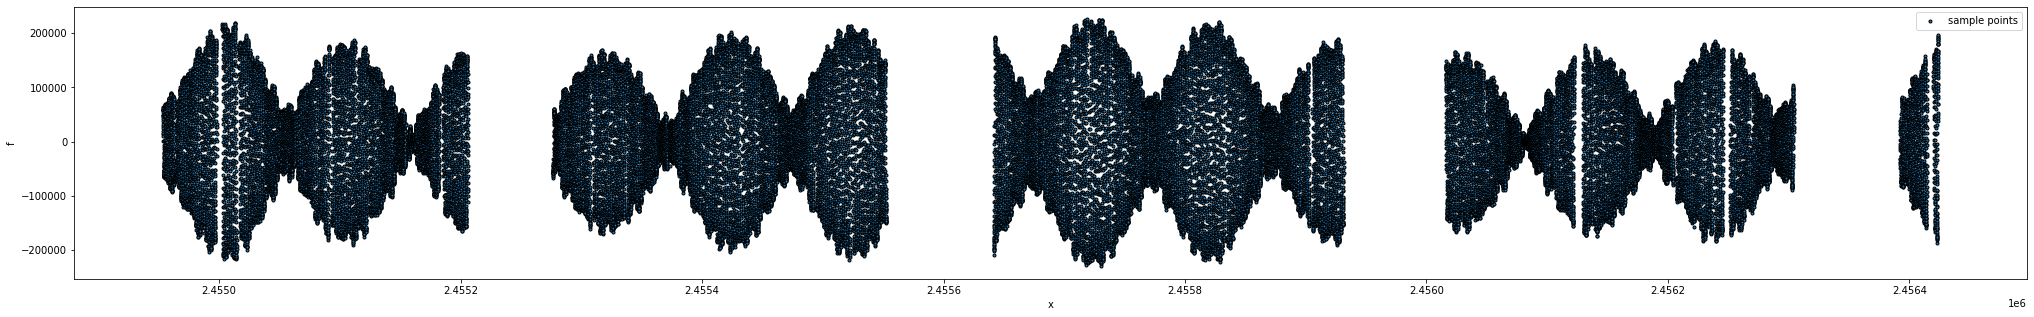

In [6]:
# Setup our figure environment
plt.figure(figsize=(35, 5))

# Plot observations
plt.plot(X, Y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["sample points"]);

Zoomed in on the first N observations

In [7]:
# This library becomes unstable at N=15125
# N=15125
N=12000 # X.shape[0]

In [8]:
train_x=X[:N]
train_y=Y[:N]

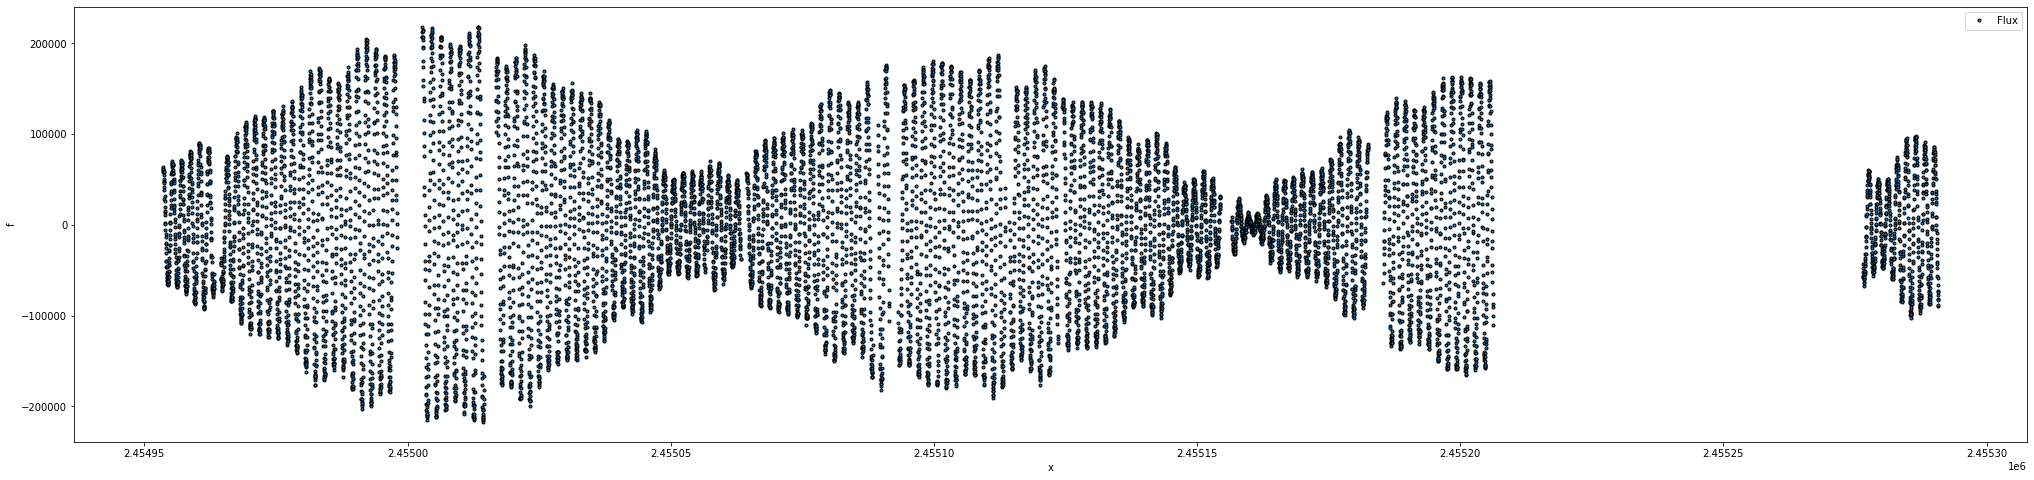

In [9]:
# Setup our figure environment
plt.figure(figsize=(35, 8))

# Plot observations
plt.plot(train_x, train_y, ".", mew=1, linewidth=1, mec="black")

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend(labels=["Flux"]);

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [10]:
def plot_kernel_samples(covariance_matrix, nr_of_samples=5):
    plt.figure(figsize=(35, 8))
    Y_sample = covariance_matrix.sample(nr_of_samples)
    N = cov_matrix.W.shape[0]
    for i in range(nr_of_samples):
        plt.plot(range(N), Y_sample[i])
    
def plot_series(data_x, data_y, smooth_x=None, smooth_y=None, var=None):
    # Plot
    plt.figure(figsize=(35, 8))
    plt.plot(data_x, data_y, ".", mew=1, linewidth=1, mec="black", label='truth')
    #plt.plot(tsmooth, ysignal, 'r', label='truth')
    #plt.errorbar(t, y, yerr, fmt='.', color='k', label='meas.')
    if not smooth_x is None:
        plt.fill_between(smooth_x, smooth_y-np.sqrt(var), smooth_y+np.sqrt(var), color='g', alpha=0.5)
        plt.plot(smooth_x, smooth_y, 'r', label='predict.')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()

def plot_1d_kernel(kernel):
    # Setup our figure environment
    plt.figure(figsize=(35, 5))

    # Predict evenly spaced points on our time-axis
    x = np.linspace(-6, 6, 1000)
    y = kernel.eval(x)
    
    # Plot observations
    plt.plot(x, y, ".", mew=1, linewidth=1, mec="black")

    # Annotate plot
    plt.xlabel("x"), plt.ylabel("f")
    plt.legend(labels=["sample points"])

def eval_2d(x):
    return np.array([x-i for i in x.tolist()])
    
def plot_2d_kernel(kernel):
    # Our sample space
    x = np.linspace(-5., 5., 250)
    grid = eval_2d(x)
    C = kernel.eval(grid)

    # Visualise covariance matrix on right hand side
    plt.pcolor(x.T, x, C)
    # Annotate plot
    plt.gca().invert_yaxis(), plt.gca().axis("image")
    plt.colorbar()

In [11]:
# Predict evenly spaced points on our time-axis
tsmooth = np.linspace(train_x.min(),train_x.max(),N)

t = train_x
y = train_y
yerr = 0

In [12]:
# Initialize the S+LEAF model
# One stochastically-driven harmonic oscillator
# One Uncorrelated measurement errors (yerr)
# One correlated calibration error term

# Calibration errors (correlated noise)
calib_id = (t//1).astype(int) # One calibration per day
caliberr = np.random.uniform(0.5, 1.5, calib_id[-1]+1)
yerr_calib = caliberr[calib_id]

cov_matrix = cov.Cov(t,
   mtn = term.Matern32Kernel(sig=0.5, rho=1))

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
# Define the function to minimize
def negloglike(x, y, cov_matrix):
   cov_matrix.set_param(x)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

# Fit
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(y, cov_matrix))

# We now use S+LEAF to predict the missing data
cov_matrix.set_param(xbest)
mu, var = cov_matrix.conditional(y, tsmooth, calc_cov='diag')

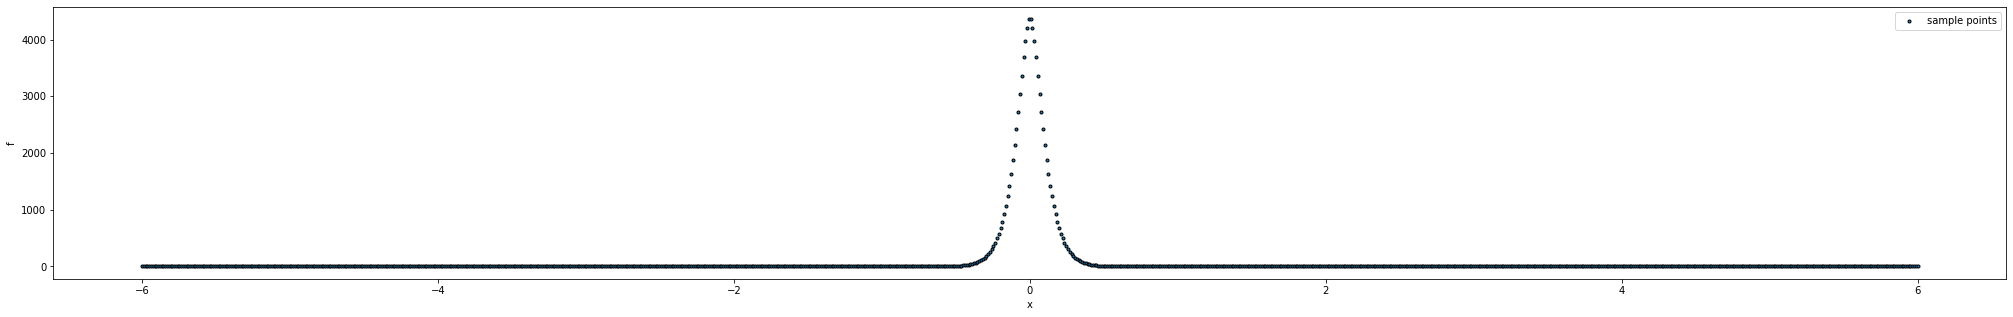

In [13]:
plot_1d_kernel(cov_matrix)

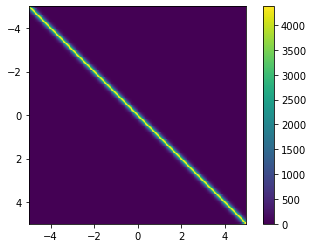

In [14]:
plot_2d_kernel(cov_matrix)

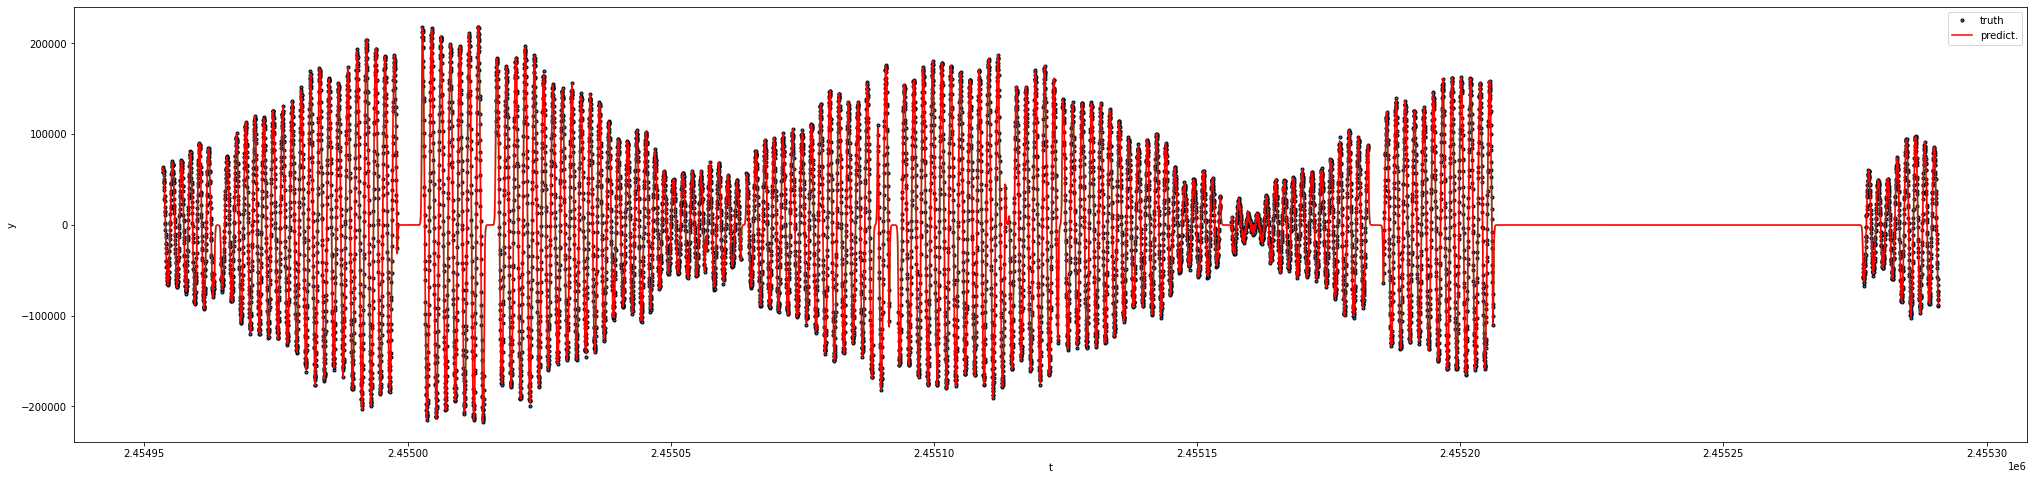

In [15]:
plot_series(train_x[:N], train_y[:N], tsmooth[:N], mu[:N], var[:N])

In [16]:
cov_matrix.param

['mtn.sig', 'mtn.rho']

In [17]:
mtn_kern = cov_matrix.kernel['mtn']
mtn_kern

In [18]:
cov_matrix.get_param('mtn.sig'), cov_matrix.get_param('mtn.rho')

(66.15217073798524, 0.10295762275707562)

RMSE

In [19]:
np.sqrt(np.nanmean((mu-train_y)**2))

121385.54999033219